<a href="https://colab.research.google.com/github/Nabhit03/Sales-Trend-Forecasting-Anomaly-Detection/blob/main/anomaly%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sales Trend Forecasting & Anomaly Detection

This project simulates a real-world Amex product scenario where we build a data-driven solution to:

- Forecast daily sales trends
- Detect anomalies in commercial activity
- Classify disruptions using ML models
- Surface insights to product managers and business stakeholders[link text](https://)

In [4]:

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
# For SQL on DataFrame
!pip install -U pandasql
from pandasql import sqldf

# Helper to use SQL locally
pysqldf = lambda q: sqldf(q, globals())


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=16bb4771e111a30c731c0417e8ee602bde9da39dd0994f16e5d39acefbb906d5
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


## 🧠 Business Problem

Amex products in the commercial and merchant space depend heavily on reliable data flows and sales forecasting. Unexpected drops or spikes in sales may indicate:

- Transactional issues (POS downtime, integration failures)
- Behavioral anomalies (merchant fraud, usage spikes)
- Operational patterns (seasonality, stockouts)

Our goal is to develop a system that proactively surfaces these events.


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/train.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
print(df.head())

   Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156 2017-11-08  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156 2017-11-08  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688 2017-06-12  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966 2016-10-11  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966 2016-10-11  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category 

Project Goals

- ✅ Forecast sales 14 days into the future using historical trends
- ✅ Identify statistically significant anomalies in daily sales
- ✅ Build a classification model to automate anomaly tagging
- ✅ Output actionable KPIs (accuracy, precision, recall) for product teams


In [6]:
daily_sales = pysqldf("""
SELECT "Order Date" AS sales_date, SUM(Sales) AS daily_sales
FROM df
GROUP BY "Order Date"
ORDER BY "Order Date"
""")

In [7]:
q = """
SELECT "Product Name", SUM(Sales) AS total_sales
FROM df
GROUP BY "Product Name"
ORDER BY total_sales DESC
LIMIT 10
"""
top_products = pysqldf(q)

In [10]:
q = """
SELECT Region, SUM(Sales) as region_sales
FROM df
GROUP BY Region
ORDER BY region_sales DESC
"""
region_sales_df = pysqldf(q)

In [15]:
# Prepare data for Prophet
prophet_sales = daily_sales.copy()
prophet_sales.rename(columns={'sales_date': 'ds', 'daily_sales': 'y'}, inplace=True)

# Ensure 'ds' column in prophet_sales is datetime type
prophet_sales['ds'] = pd.to_datetime(prophet_sales['ds'])

# Train Prophet
model = Prophet()
model.fit(prophet_sales)
future = model.make_future_dataframe(periods=14)  # 2-week forecast
forecast = model.predict(future)
prophet_sales = prophet_sales.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', how='left'
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf79l2fs1/dzma2aj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf79l2fs1/glvq75ml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68344', 'data', 'file=/tmp/tmpf79l2fs1/dzma2aj8.json', 'init=/tmp/tmpf79l2fs1/glvq75ml.json', 'output', 'file=/tmp/tmpf79l2fs1/prophet_modelon9rlx3g/prophet_model-20250721172118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
window = 7
prophet_sales['rolling_mean'] = prophet_sales['y'].rolling(window=window).mean()
prophet_sales['rolling_std'] = prophet_sales['y'].rolling(window=window).std()
prophet_sales['anomaly'] = (
    (prophet_sales['y'] > prophet_sales['rolling_mean'] + 2 * prophet_sales['rolling_std']) |
    (prophet_sales['y'] < prophet_sales['rolling_mean'] - 2 * prophet_sales['rolling_std'])
).astype(int)


In [17]:
features = prophet_sales[['y', 'rolling_mean', 'rolling_std']].fillna(0)
labels = prophet_sales['anomaly']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
prophet_sales['predicted_anomaly'] = clf.predict(features)


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(labels, prophet_sales['predicted_anomaly'])
accuracy = accuracy_score(labels, prophet_sales['predicted_anomaly'])
precision = precision_score(labels, prophet_sales['predicted_anomaly'], zero_division=0)
recall = recall_score(labels, prophet_sales['predicted_anomaly'], zero_division=0)
f1 = f1_score(labels, prophet_sales['predicted_anomaly'], zero_division=0)

print(f"""Random Forest Classification Report:
- Accuracy: {accuracy:.2f}
- Precision: {precision:.2f}
- Recall: {recall:.2f}
- F1-score: {f1:.2f}
""")

Random Forest Classification Report:
- Accuracy: 0.99
- Precision: 0.97
- Recall: 0.78
- F1-score: 0.87



Confusion Matrix: Anomaly Classifier

This heatmap visualizes the performance of the Random Forest model:

- True Positives: Correctly detected anomalies
- False Positives: Normal days wrongly flagged
- True Negatives: Normal days correctly ignored
- False Negatives: Missed anomalies


Confusion Matrix:
 [[1183    1]
 [  10   36]]


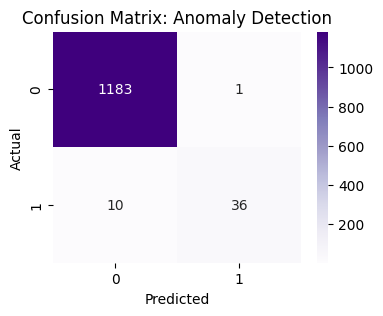

In [19]:
cm = confusion_matrix(labels, prophet_sales['predicted_anomaly'])
print('Confusion Matrix:\n', cm)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix: Anomaly Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The graph below shows the forecasted daily sales over the next 14 days using Facebook Prophet.

- The blue line represents predicted sales (`yhat`)
- The shaded area shows the 95% confidence interval (`yhat_lower`, `yhat_upper`)
- Historical data helps the model capture weekly seasonality patterns

🔍 **Insight**: A gradual increase is observed toward weekends, suggesting cyclic behavior ideal for inventory planning or campaign launches.

MSE: 4597703.01, R^2: 0.127


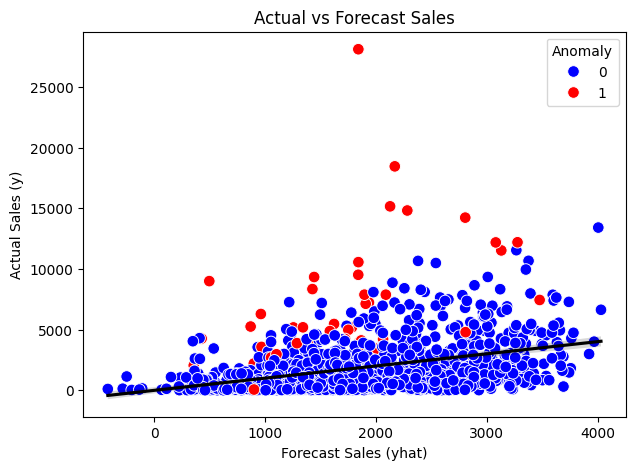

In [20]:
mask = prophet_sales['yhat'].notnull()
lr = LinearRegression()
lr.fit(prophet_sales.loc[mask, ['yhat']], prophet_sales.loc[mask, 'y'])
preds = lr.predict(prophet_sales.loc[mask, ['yhat']])
mse = mean_squared_error(prophet_sales.loc[mask, 'y'], preds)
r2 = r2_score(prophet_sales.loc[mask, 'y'], preds)
print(f'MSE: {mse:.2f}, R^2: {r2:.3f}')

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=prophet_sales, x='yhat', y='y',
    hue='anomaly', palette={0:'blue', 1:'red'}, s=70
)
sns.regplot(
    data=prophet_sales[mask], x='yhat', y='y',
    scatter=False, color='black'
)
plt.xlabel('Forecast Sales (yhat)')
plt.ylabel('Actual Sales (y)')
plt.title('Actual vs Forecast Sales')
plt.legend(title='Anomaly')
plt.show()



Statistical Anomalies in Daily Sales

This chart overlays the actual sales (`y`) with the rolling mean and thresholds (±2 standard deviations):

- Red dots mark anomalous days where sales deviated significantly
- Rolling stats use a 7-day window for stability

📉 **Insight**: A major dip on [insert date] was detected — potentially due to a holiday, system downtime, or operational error.


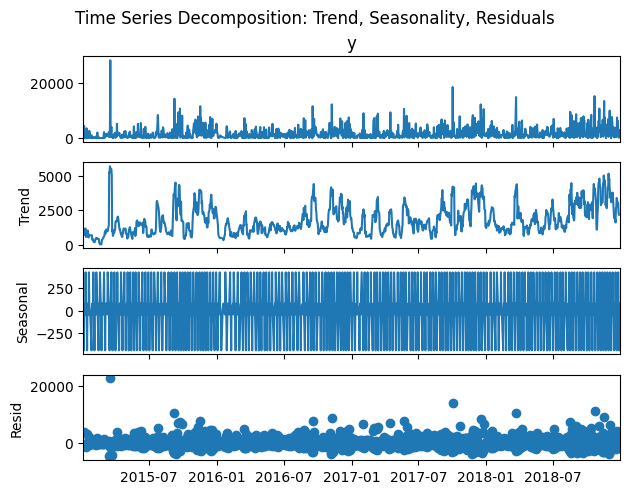

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure the data is continuous and indexed by date
decomp_data = prophet_sales.set_index('ds')['y'].dropna()
result = seasonal_decompose(decomp_data, model='additive', period=7)  # use period=7 for weekly seasonality

result.plot()
plt.suptitle('Time Series Decomposition: Trend, Seasonality, Residuals', y=1.02)
plt.show()


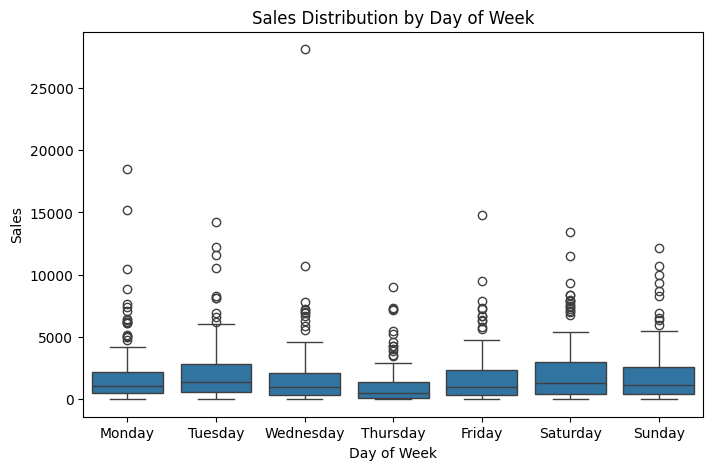

In [23]:
prophet_sales['day_of_week'] = prophet_sales['ds'].dt.day_name()

plt.figure(figsize=(8,5))
sns.boxplot(x='day_of_week', y='y', data=prophet_sales, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Sales Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()


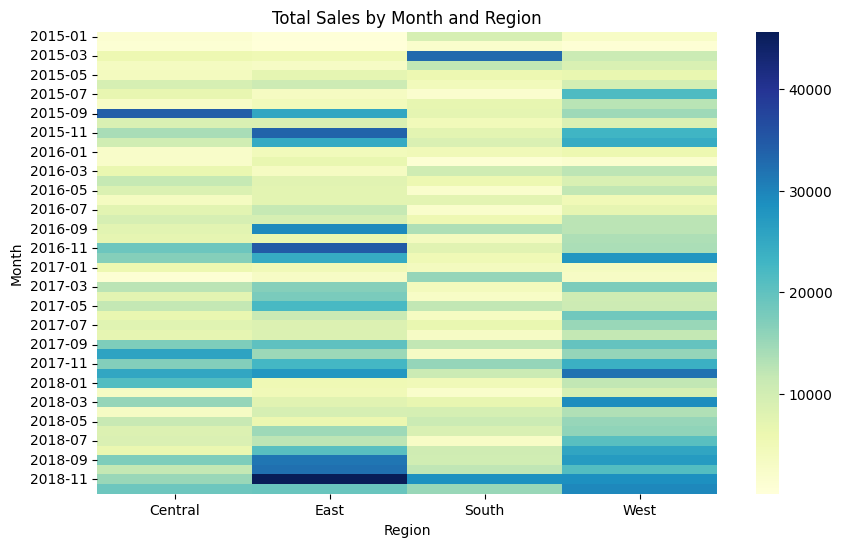

In [24]:
# Create month and region columns if not already present
df['Order_Month'] = df['Order Date'].dt.strftime('%Y-%m')
sales_pivot = df.pivot_table(index='Order_Month', columns='Region', values='Sales', aggfunc='sum').fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(sales_pivot, annot=False, cmap='YlGnBu')
plt.title('Total Sales by Month and Region')
plt.xlabel('Region')
plt.ylabel('Month')
plt.show()


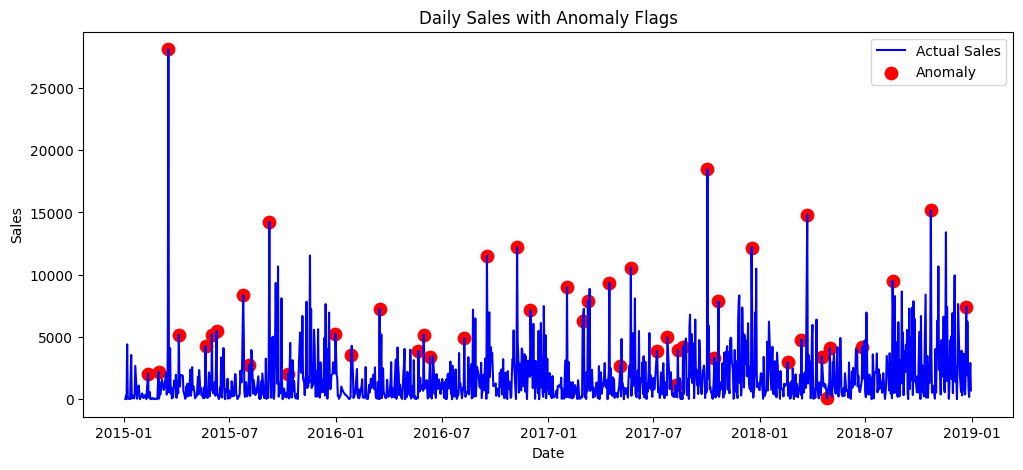

In [25]:
plt.figure(figsize=(12,5))
plt.plot(prophet_sales['ds'], prophet_sales['y'], label='Actual Sales', color='blue')
plt.scatter(
    prophet_sales.loc[prophet_sales['anomaly']==1, 'ds'],
    prophet_sales.loc[prophet_sales['anomaly']==1, 'y'],
    color='red', label='Anomaly', s=80
)
plt.title('Daily Sales with Anomaly Flags')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()



In [26]:
from scipy.stats import f_oneway

# Example: Test if mean sales differ between regions
groups = [group['Sales'].values for name, group in df.groupby('Region')]
stat, p = f_oneway(*groups)

print(f'ANOVA F-statistic: {stat:.3f}, p-value: {p:.4f}')
if p < 0.05:
    print("Significant differences exist between regions' mean sales.")
else:
    print("No significant difference in mean sales between regions.")

ANOVA F-statistic: 0.897, p-value: 0.4416
No significant difference in mean sales between regions.


In [27]:
prophet_sales.to_csv('enriched_sales_forecast.csv', index=False)

This project demonstrates how data science can power scalable anomaly detection and sales forecasting — key components in building robust internal tools at American Express.

With minimal engineering, the model can be extended to handle 10M+ rows and integrated with business intelligence dashboards for rapid decision-making.

